In [210]:
%cd ~/Documents/comp3610A3/
import polars as pl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse._matrix import spmatrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, precision_score, roc_auc_score
import plotly.graph_objects as go
import polars as pl
import numpy as np

import scipy  as sp
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

C:\Users\Lorenzo\Documents\comp3610A3


C:\Users\Lorenzo\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
C:\Users\Lorenzo\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [211]:
def get_metrics(y_true: np.ndarray, y_pred: np.ndarray, model_name: str) -> dict:
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=1),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC AUC": roc_auc_score(y_true, y_pred),
        "True Negative": tn,
        "False Positive": fp,
        "False Negative": fn,
        "True Positive": tp,
    }

In [212]:
VALID_CATEGORIES: list[str] = [
    "Gift_Cards",
    "Subscription_Boxes",
    "Magazine_Subscriptions",
]

In [213]:
df: pl.DataFrame = pl.concat([
    pl.read_parquet(f"data/intermediate/{category}.parquet")
    for category in VALID_CATEGORIES
])

In [214]:
query: pl.Expr = (pl.col("rating") > 3).cast(pl.Int8).alias("rating")
df: pl.DataFrame = df.with_columns(query)
df = df["rating", "text"]
df

rating,text
i8,str
1,"""Just what I needed to give as …"
1,"""can't get easier to reload and…"
1,"""Gift"""
1,"""Was perfect as a house warming…"
0,"""Gift card seems fine but the g…"
…,…
1,"""Great articles and cartoons"""
1,"""Received this magazine right o…"
1,"""Love the Geographic. This is t…"


In [215]:
X: pl.Series = df["text"] #vectorizer breaks if a dataframe (it tries to call to lowwer on the series)
y: pl.Series = df["rating"]

In [216]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [217]:
vectorizer = TfidfVectorizer(
    lowercase=True,
    token_pattern=r'\b\w+\b', 
    min_df=5,
    max_df=0.8,
    stop_words="english"
)

X_train: spmatrix = vectorizer.fit_transform(X_train)
X_test: spmatrix = vectorizer.transform(X_test)

In [218]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [ ]:

"""Add TFID to results dataframe"""
results: list[dict] = []
results.append(get_metrics(y_test, model.predict(X_test), "Logistic Regression"))

In [ ]:
results_df = pl.DataFrame(results)
results_df
"""Use results dataframe to do comparitive ROC AUC, as well as precision,recall, f1score bar chart"""
"""Do side by side confusion matrices or top->down if it won't look gookd"""
"""
Convert to plotly, some of this can be found in my A2 zip.
"""

Model,Accuracy,Precision,Recall,F1 Score,ROC AUC,True Negative,False Positive,False Negative,True Positive
str,f64,f64,f64,f64,f64,i64,i64,i64,i64
"""Logistic Regression""",0.915269,0.929807,0.970331,0.949637,0.814554,5539,2869,1162,38004


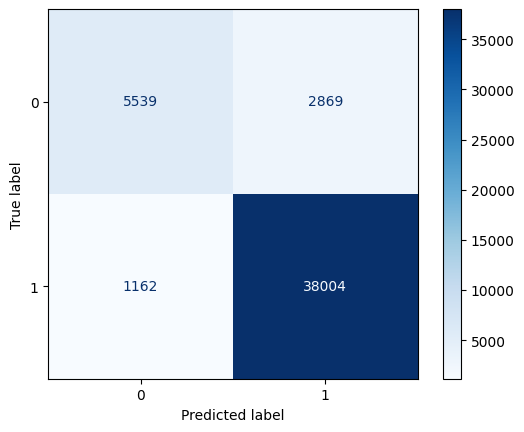

In [ ]:
confusion_matrix=ConfusionMatrixDisplay(confusion_matrix(y_test, model.predict(X_test)), display_labels=model.classes_)
confusion_matrix.plot(cmap="Blues")
"""REplace with plotly"""